### Figure 1
* Expt design schematic
* Expt design patterns in space and time
* Example set of traces
* Calib of stimuli: desensitization
* Control for CA3 responses to patterns.
* CA3 heatmap
* CA3 analysis with respect to freq
* CA3 expected pattern responses

In [1]:
from   pathlib      import Path

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.stats   import kruskal, wilcoxon, mannwhitneyu, ranksums
from scipy.optimize import curve_fit

from PIL            import Image

# from eidynamics     import utils, data_quality_checks, ephys_classes, plot_tools, expt_to_dataframe
# from eidynamics     import pattern_index
# from eidynamics     import abf_to_data
from eidynamics.fit_PSC     import find_sweep_expected
# from Findsim        import tab_presyn_patterns_LR_43
# import parse_data
from eidynamics     import utils, plot_tools
from eidynamics     import pattern_index
import all_cells
import plotFig2
from stat_annotate import *

# sns.set_context('paper')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']

color_E = "flare"
color_I = "crest"
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}
%matplotlib widget
Fs = 2e4

freq_sweep_pulses = np.arange(9)

>> Working on:  C:\Users\adity\OneDrive\NCBS


In [2]:
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure1v3_GRC")
data_path                    = Path(r"parsed_data\\")
cell_data_path               = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\Screened_cells\\")

In [3]:
# Load the dataset
freq_sweep_cc_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_CC_long.h5" 
df = pd.read_hdf(freq_sweep_cc_datapath, key='data')

# short data path for all protocols (df2) (processed dataframe with metadata and analysed params)
dfshortpath     = r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_allprotocols_with_fpr_values.h5"
xc_all_shortdf  = pd.read_hdf(dfshortpath, key='data')

# expanded dataframe (processed dataframe with metadata and analysed params)
# expanded_data_path = r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_combined_expanded.h5"
# xc_FS_analyseddf = pd.read_hdf(expanded_data_path, key='data')
# print(xc_FS_analyseddf.shape)

# DataFrame metadata columns
num_metadata_columns = 49
num_dataflag_columns = -10
column_name_abbreviations = utils.analysed_properties1_abbreviations
metadata_fields = (df.columns[:num_metadata_columns]).to_list()
dataflag_fields = (df.columns[-24:-14]).to_list()

### Data screening

In [4]:
# data screening based on dataflag_fields
dfslice = df[
            (df['location'] == 'CA1') &
            (df['numSq'].isin([1,5,15])) &
            (df['AP'] == 0) &
            (df['IR'] >50) & (df['IR'] < 300) &
            (df['tau'] < 40) & 
            (df['intensity'] == 100) &
            (df['pulseWidth'] == 2) &
            # (df['sweepBaseline'] < -50) &
            (df['condition'] == 'Control') &
            (df['ch0_response']==1) &
            # (df['spike_in_stim_period'] == 0) &
            (df['spike_in_baseline_period'] == 0) &
            (df['ac_noise_power_in_ch0'] < 40) 
        ]
print(df.shape, dfslice.shape)
screened_trialIDs = dfslice['trialID'].unique()

print(f"Unique cells in screened data: {dfslice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {dfslice['trialID'].nunique()}")

df2 = xc_all_shortdf[(xc_all_shortdf['trialID'].isin(screened_trialIDs)) ]
# df3 = xc_FS_analyseddf[xc_FS_analyseddf['trialID'].isin(screened_trialIDs)]

(4971, 80073) (2316, 80073)
Unique cells in screened data: 16
Unique sweeps in screened data: 2316


### Main

Plotting all 4 signals on a single plot
remapping to default


C:\Users\adity\AppData\Local\Temp\ipykernel_26468\2287820738.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[ (df_temp['cellID']==cell) & (df_temp['numSq']==s), 'field_fpr_norm'] = field_fpr_norm
C:\Users\adity\AppData\Local\Temp\ipykernel_26468\2287820738.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[ (df_temp['cellID']==cell) & (df_temp['numSq']==s), 'cell_fpr_norm'] = cell_fpr_norm
c:\venvs\venv-ephys\Lib\site-packages\seaborn\axisgrid.py:1696: RuntimeWarning: More t

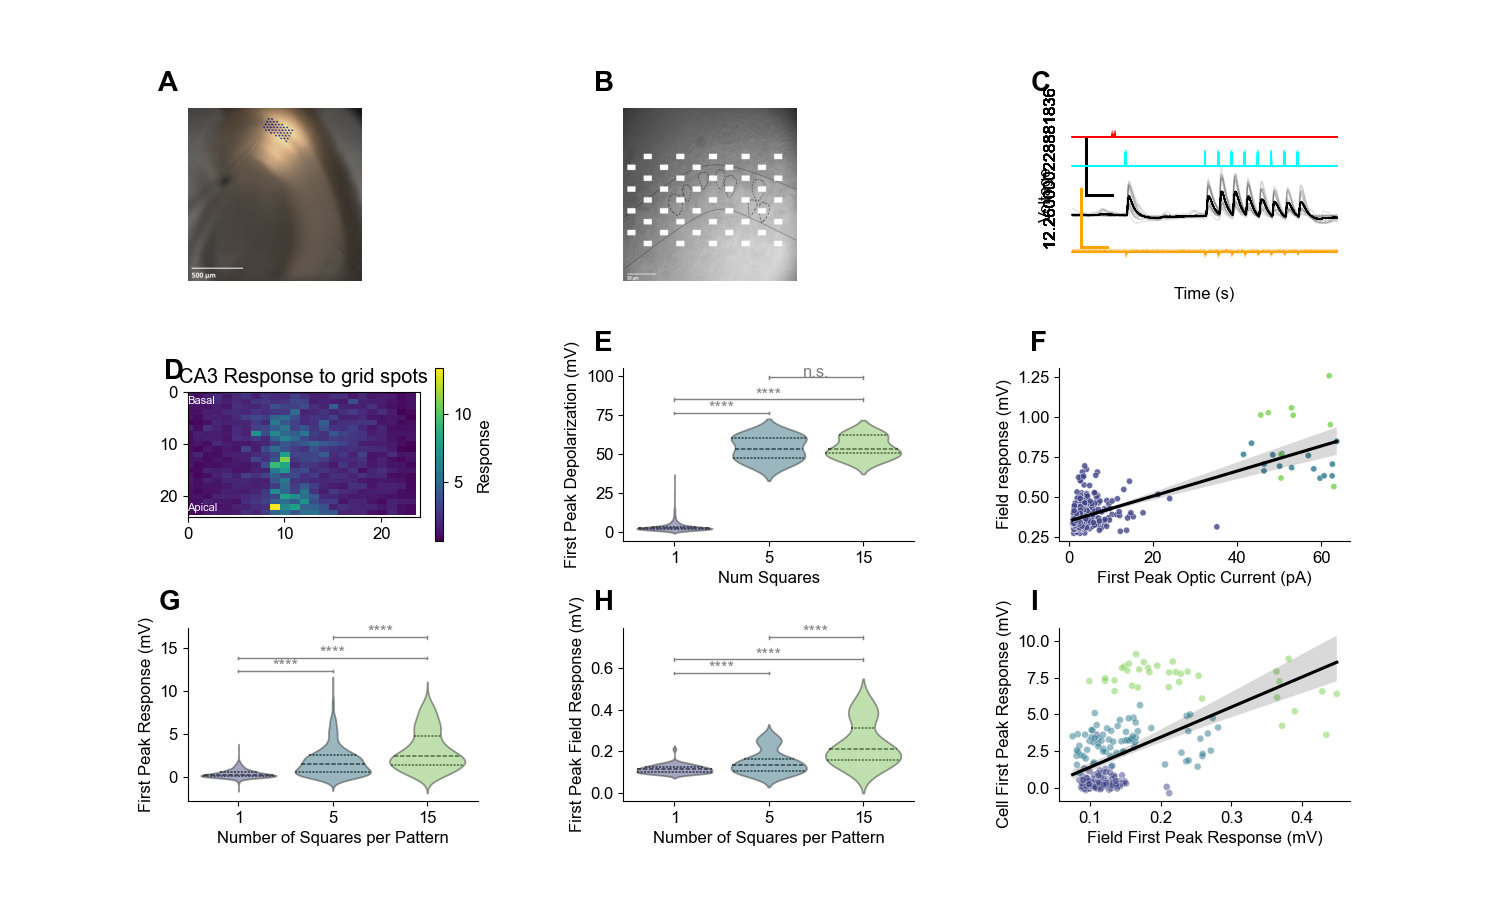

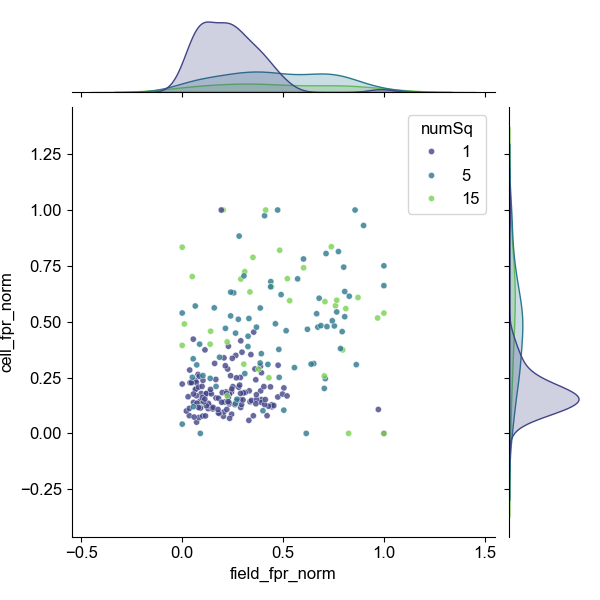

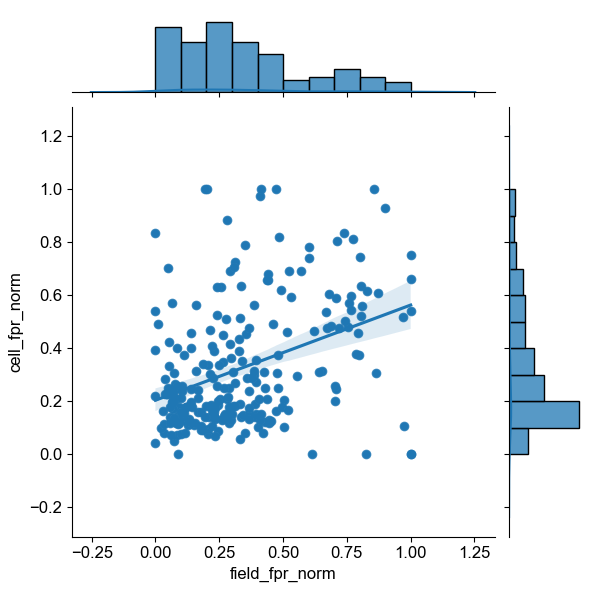

In [15]:
# Figure 1 initialization
# aspect ratio of the figure = 1
w, h = [15, 9]

fig1, [[ax1a, ax1b, ax1c],[ax1d, ax1e, ax1f],[ax1g, ax1h, ax1i]] = plt.subplots(3,3, figsize=(w, h),)
# have more space between suplots
fig1.subplots_adjust(hspace=0.5, wspace=0.5)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Fig 1A: Slice, polygon projection, and recording electrodes
ax1a.text(-0.1, 1.1, 'A', transform=ax1a.transAxes, size=20, weight='bold')
image1_path = all_cells.project_path_root / r"Lab\Projects\EI_Dynamics\Analysis\paper_figure_matter\slice_electrode_expression_cropped_with_scalebar_blue_polygon.png"
im1 = Image.open(image1_path)
# get the size of the image
im1_width, im1_height = im1.size
# get the aspect ratio of the ax1a axes object
ax1a_ratio = ax1a.get_window_extent().width / ax1a.get_window_extent().height

# change the axis limits so that verticle side of the image fits the axis and horizontal side is aligned left on the axis
ax1a.set_ylim(0, im1_height)
ax1a.set_xlim(0, im1_height*ax1a_ratio)
# plot the image
ax1a.imshow(im1, extent=[0, im1_width, 0, im1_height], aspect=1)
ax1a.axis('off')

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Fig 1B: Grid Pattern in Space overlaid on CA3 slice at 40x
ax1b.text(-0.1, 1.1, 'B', transform=ax1b.transAxes, size=20, weight='bold')
image2_path = all_cells.project_path_root / r'Lab\Projects\EI_Dynamics\Analysis\paper_figure_matter\CA3-polygonFrame_figure_with_cellboundaries.png'
im2 = Image.open(image2_path)
im2_width, im2_height = im2.size
# ax1b.imshow(im2)

ax1b.set_ylim(0, im1_height)
ax1b.set_xlim(0, im1_height*ax1a_ratio)
ax1b.imshow(im2, extent=[0, im1_width, 0, im1_height], aspect=1)
ax1b.axis('off')
# ax1b.set_anchor('W')

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Fig 1C: Protocol Freq Sweep
sample_cell = 3611  #screened_cc_cells[2] # 3131
ax1c.text(-0.1, 1.1, 'C', transform=ax1c.transAxes, size=20, weight='bold')
data = dfslice[(dfslice['pulseTrainStart']==0.5) & (dfslice['numSq']==15) &  (dfslice['stimFreq']==20)]
fig1, ax1c, _ = plot_tools.plot_data_from_df(data, data_start_column=49,combine=True, fig=fig1, ax=ax1c, )
# set legend inside the plot
# ax1c.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), frameon=True) # legend removed to save space
# simplify
plot_tools.simplify_axes(ax1c, splines_to_keep=[], )
#remove legend
ax1c.legend([],[], frameon=False)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1D: CA3 heatmap
# import heatmap data
df_CA3_heatmap = pd.read_hdf(r"parsed_data\CA3_recording_3161_grid_response_pivot.h5")

grid_aspect_ratio = pattern_index.polygon_frame_properties['aspect_ratio']

h = 8
w = grid_aspect_ratio*h
# ax1d.suptitle('Peak Response to 9 pulses in 24 hexagonal grid squares', fontsize=16)

pulse = 0
# get data from column=i and all rows
vals = df_CA3_heatmap[pulse].values
# get index values
idx = (df_CA3_heatmap[pulse].index.get_level_values(0).values) - 1

# make heatmaps
plot_tools.plot_grid(spot_locs=idx, spot_values=vals, grid=[24,24], cmap='viridis', ax=ax1d, vmax=15)

# add text to the plot on top left corner of the heatmap in white color
ax1d.text(0.0, 0.9, 'Basal', transform=ax1d.transAxes, size=8,  color='white')
# add text to the plot on bottom left corner of the heatmap
ax1d.text(0.0, 0.05, 'Apical', transform=ax1d.transAxes, size=8, color='white')
ax1d.set_title('CA3 Response to grid spots')
ax1d.text(-0.1, 1.1, 'D', transform=ax1d.transAxes, size=20, weight='bold')

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1E: CA3 pulse response
ax1e.text(-0.1, 1.1, 'E', transform=ax1e.transAxes, size=20, weight='bold')
df_temp = xc_all_shortdf[ (xc_all_shortdf['cellID']==3161) ]

# plot a relationship between cell_fpr and field_fpr using a scatter plot (options: box, strip, swarm, violin, boxen)
# sns.stripplot(data=df_temp, x="cell_fpr_max",  y='numSq', s=5, alpha=0.8, jitter=True, orient="h", ax=ax1e, hue='numSq', palette=color_squares,  linewidth=0.5)
sns.violinplot(data=df_temp, x="numSq", y="cell_fpr_max", hue="numSq", palette=color_squares, ax=ax1e, alpha=0.5, inner='quart', split=False, dodge=False, zorder=3)
[part.set_edgecolor((part.get_edgecolor()[:],  0)) for part in ax1e.get_children() if isinstance(part, mpl.collections.PolyCollection)]

# ax1e.set_ylabel('CA3 cell Response (mV)')
# ax1e.set_xlabel('Number of Squares per Pattern')
# no legend
ax1e.legend([],[], frameon=False)

# remove top and right spines
ax1e.spines['top'].set_visible(False)
ax1e.spines['right'].set_visible(False)

# statistics
pairwise_annotate_violin_plot(ax1e, df_temp, x='numSq', y='cell_fpr_max', stat=mannwhitneyu, add_line=True, offset=0.1, color='grey', coord_system='', fontsize=12, zorder=10)

# set labels
ax1e.set_ylabel('First Peak Depolarization (mV)')
ax1e.set_xlabel('Num Squares')
# legend off
ax1e.legend([],[], frameon=False)
# remove top and right spines
ax1e.spines['top'].set_visible(False)
ax1e.spines['right'].set_visible(False)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1F: CA3 cell_fpr vs field_fpr
ax1f.text(-0.1, 1.1, 'F', transform=ax1f.transAxes, size=20, weight='bold')

# add scatterplot on ax1f
sns.scatterplot(data=df_temp, x="cell_fpr_max", y="field_fpr_p2p", hue='numSq', palette=color_squares, ax=ax1f, alpha=0.8, s=20, legend=True)
# add regression line to the scatterplot
sns.regplot(data=df_temp, x="cell_fpr_max", y="field_fpr_p2p", ax=ax1f, scatter=False, color='black', ci=95)
# calculate the correlation coefficient
resultsCA3 = linregress(df_temp["cell_fpr_max"], df_temp["field_fpr_p2p"])

ax1f.set_xlabel('First Peak Optic Current (pA)')
ax1f.set_ylabel('Field response (mV)')
# legend off
ax1f.legend([],[], frameon=False)
# remove top and right spines
ax1f.spines['top'].set_visible(False)
ax1f.spines['right'].set_visible(False)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1G: First peak response | cell_fpr_max vs numSq

ax1g.text(-0.1, 1.1, 'G', transform=ax1g.transAxes, size=20, weight='bold')
# ax1g.set_title('First Peak Response')

# sns.stripplot(data=df_temp,  x="numSq", y="cell_fpr_max", hue="numSq", palette=color_squares, ax=ax1g, alpha=0.8, s=2, jitter=0.25, orient="v", linewidth=0.25)
sns.violinplot(data=df2, x="numSq", y="cell_fpr_max", hue="numSq", palette=color_squares, ax=ax1g, alpha=0.5, inner='quart', split=False, dodge=False,zorder=3)
[part.set_edgecolor((part.get_edgecolor()[:],  0)) for part in ax1g.get_children() if isinstance(part, mpl.collections.PolyCollection)]

ax1g.set_ylabel('First Peak Response (mV)')
ax1g.set_xlabel('Number of Squares per Pattern')
ax1g.legend([],[], frameon=False)
# remove top and right spines
ax1g.spines['top'].set_visible(False)
ax1g.spines['right'].set_visible(False)

## Statistics for the violin plots: mannwhitneyu Rank Sum Test across numSq values
pairwise_annotate_violin_plot(ax1g, df2, x='numSq', y='cell_fpr_max', stat=mannwhitneyu, add_line=True, offset=0.1, color='grey', coord_system='', fontsize=12, zorder=10)
            

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1H: Field FPR histogram, should be same style as 1D
ax1h.text(-0.1, 1.1, 'H', transform=ax1h.transAxes, size=20, weight='bold')
# plot a relationship between field_fpr and field_stpr using a scatter plot
df_temp = df2[ (df2['fieldData']==True)  & (df2['fieldunit']=='mV')   ] 

# sns.stripplot(data=df_temp, x="numSq", y="field_fpr_p2p", hue="numSq", palette=color_squares, ax=ax1h, alpha=0.8, s=2, jitter=0.25, orient="v", linewidth=0.25)
sns.violinplot(data=df_temp, x="numSq", y="field_fpr_p2p", hue="numSq", palette=color_squares, ax=ax1h, alpha=0.5, inner='quart', split=False, dodge=False,zorder=3)
[part.set_edgecolor((part.get_edgecolor()[:],  0)) for part in ax1h.get_children() if isinstance(part, mpl.collections.PolyCollection)]

ax1h.set_ylabel('First Peak Field Response (mV)')
ax1h.set_xlabel('Number of Squares per Pattern')
# no legend
ax1h.legend([],[], frameon=False)

# remove top and right spines
ax1h.spines['top'].set_visible(False)
ax1h.spines['right'].set_visible(False)

# statistics
pairwise_annotate_violin_plot(ax1h, df_temp, x='numSq', y='field_fpr_p2p', stat=mannwhitneyu, add_line=True, offset=0.1, color='grey', coord_system='', fontsize=12, zorder=10)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Fig 1I: relationship between cell_fpr and field_fpr
ax1i.text(-0.1, 1.1, 'I', transform=ax1i.transAxes, size=20, weight='bold')
df_temp = df2[(df2['fieldunit']=='mV') ] 

numCells = len(np.unique(df_temp['cellID']))
# pick as many colors as there are cells
colors = sns.color_palette('Paired', numCells)

# plot a relationship between cell_fpr and field_fpr using a scatter plot, but normalize for each cell
# sns.scatterplot(df_temp, x="field_fpr", y="cell_fpr", hue='cellID', style='numSq', palette='Dark2', ax=ax1i, alpha=0.8, s=49, legend=True)
# for each cell normalize the field_fpr and cell_fpr before plotting
markerstyle = {1: 'P', 5:'*', 15: 'X'}
for i,cell in enumerate(np.unique(df_temp['cellID'])):
    for s in np.unique(df_temp['numSq']):
        df_temp_cell = df_temp[ (df_temp['cellID']==cell) & (df_temp['numSq']==s)]
        if len(df_temp_cell) > 0:  # Check if the dataframe is not empty
            field_fpr = df_temp_cell['field_fpr_p2p']
            cell_fpr = df_temp_cell['cell_fpr_max']
            field_fpr_norm = (field_fpr - np.min(field_fpr))/(np.max(field_fpr) - np.min(field_fpr))
            cell_fpr_norm = (cell_fpr - np.min(cell_fpr))/(np.max(cell_fpr) - np.min(cell_fpr))
            # save the norm values back in the dataframe
            df_temp.loc[ (df_temp['cellID']==cell) & (df_temp['numSq']==s), 'field_fpr_norm'] = field_fpr_norm
            df_temp.loc[ (df_temp['cellID']==cell) & (df_temp['numSq']==s), 'cell_fpr_norm'] = cell_fpr_norm
            # add scatteplot for each cell with normalized values of field_fpr and cell_fpr while also adding the cellID as a label, and adding marker style for different numSq values
            
sns.scatterplot(data=df_temp, x='field_fpr_p2p', y='cell_fpr_max', s=25, hue='numSq', palette=color_squares, ax=ax1i, alpha=0.5)
# add regression line to the scatterplot
sns.regplot(data=df_temp, x="field_fpr_p2p", y="cell_fpr_max", ax=ax1i, scatter=False, color='black', ci=95)
from scipy.stats import linregress
# calculate the correlation coefficient
resultsCA3_CA1 = linregress(df_temp["field_fpr_norm"], df_temp["cell_fpr_norm"])

# add cell labels as legend
ax1i.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   

fig1fv1 = sns.jointplot(data=df_temp, x="field_fpr_norm", y="cell_fpr_norm", hue="numSq", palette=color_squares, alpha=0.8, s=20, legend=True,)
fig1fv2 = sns.jointplot(data=df_temp, x="field_fpr_norm", y="cell_fpr_norm",)
fig1fv2.plot(sns.regplot, sns.kdeplot)

ax1i.set_xlabel('Field First Peak Response (mV)')
ax1i.set_ylabel('Cell First Peak Response (mV)')
# legend off
ax1i.legend([],[], frameon=False)
# remove top and right spines
ax1i.spines['top'].set_visible(False)
ax1i.spines['right'].set_visible(False)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # save figure
figure_name = 'Figure1'
fig1.savefig(paper_figure_export_location /  (figure_name + '.png'), dpi=300, bbox_inches='tight')
fig1.savefig(paper_figure_export_location /  (figure_name + '.svg'), dpi=300, bbox_inches='tight')
fig1fv1.savefig(paper_figure_export_location /  ('Figure1f_jointplot.svg'), dpi=300, bbox_inches='tight')
fig1fv1.savefig(paper_figure_export_location /  ('Figure1f_jointplot.png'), dpi=300, bbox_inches='tight')
fig1fv2.savefig(paper_figure_export_location /  ('Figure1f_jointplot_reg.svg'), dpi=300, bbox_inches='tight')
fig1fv2.savefig(paper_figure_export_location /  ('Figure1f_jointplot_reg.png'), dpi=300, bbox_inches='tight')


In [16]:
print(resultsCA3, '\n', resultsCA3_CA1)

LinregressResult(slope=0.00778350519384438, intercept=0.3516333229107432, rvalue=0.7466563560946342, pvalue=5.875454237574137e-108, stderr=0.0002835715139151108, intercept_stderr=0.0033084481456792238) 
 LinregressResult(slope=0.3594015981683731, intercept=0.2035233061291027, rvalue=0.38311475611434076, pvalue=1.052928200238417e-09, stderr=0.05652603088661507, intercept_stderr=0.02393972394543315)


### Fig1E --> Fig 1E

In [3]:
# 1. Desensitization from within a CA3 cell: Over 8-9 pulses for each grid square, plot the line diagram of normalized response vs pulse index (1 cell, lots of grid points)
# 2. Desensitization from CA3 cell layer: plot across pulses, normazlied field response for 1sq, 5sq, 15sq data vs pulse index
# 3. To show optical stimulation: plot CA3 AP on a grid and depolarization on the grid (less data, only 1 cell)

In [3]:
# Fig E: numSq vs 'cell_fpr'
# 1. combine the grid and freqsweep data
# 2. make two subplots, first for AP, second for subthreshold responses
# 3. Plot response vs numSq

freq_sweep_cc_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_CC_long.h5" 
df = pd.read_hdf(freq_sweep_cc_datapath, key='data')
df = df[df['cellID']==3161]
print(df.shape)
# grid dataframe
grid_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_grid_CC_long.h5" 
df2 = pd.read_hdf(grid_datapath, key='data')
print(df2.shape)
df2 = df2[df2['cellID']==3161]
print(df2.shape)

# concatenate the two dataframes
df3 = pd.concat([df, df2])

(24, 80073)
(5760, 80059)
(576, 80059)


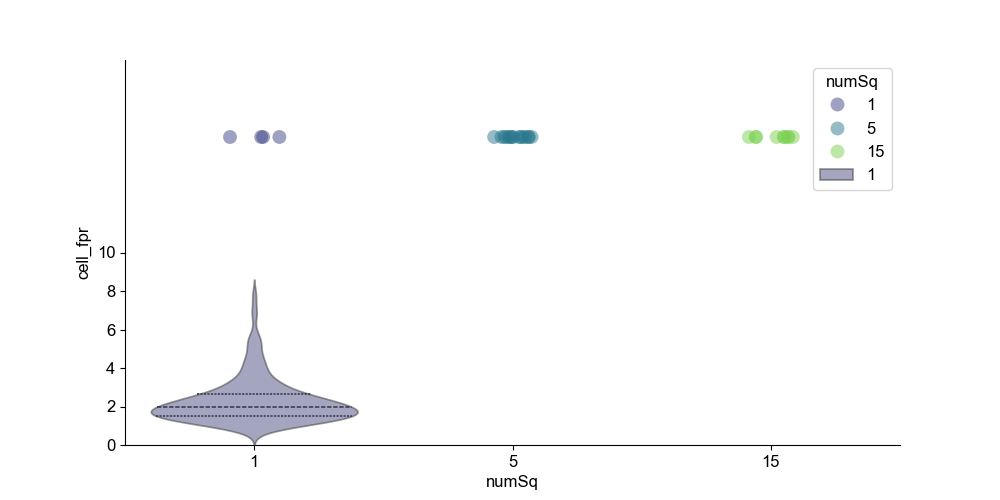

In [4]:
df3['cell_fpr'] = df3.apply(lambda x: x[4049:4249].max(), axis=1)
# if cell_fpr is greater than threshold mV, then it is an AP, else it is a subthreshold response
threshold = 8
df3['AP'] = df3['cell_fpr'] > threshold
# if 'cell_fpr' is greater than threshold, then cell_fpr = threshold*2, else cell_fpr = cell_fpr
df3['cell_fpr'] = df3.apply(lambda x: threshold*2 if x['AP'] else x['cell_fpr'], axis=1)
figE, axE = plt.subplots(1,1, figsize=(10,5))
# plot the subthreshold data
sns.stripplot(data=df3[df3['AP']==True], x="numSq", y='cell_fpr', hue="numSq", size=10, palette=color_squares, ax=axE, alpha=0.5, zorder=5)
sns.violinplot(data=df3[df3['AP']==False], x="numSq", y="cell_fpr", hue="numSq", palette=color_squares, ax=axE, alpha=0.5, inner='quart', split=False, dodge=False, zorder=3)
[part.set_edgecolor((part.get_edgecolor()[:],  0)) for part in axE.get_children() if isinstance(part, mpl.collections.PolyCollection)]

# keep yticks on from 0 to 10
axE.set_ylim(0, 20)
axE.set_yticks(np.arange(0, 11, 2))

# remove spines
axE.spines['top'].set_visible(False)
axE.spines['right'].set_visible(False)

# save it as a figure
figure_name = 'Figure1E'
# figE.savefig(paper_figure_export_location /  (figure_name + '.png'), dpi=300, bbox_inches='tight')
# figE.savefig(paper_figure_export_location /  (figure_name + '.svg'), dpi=300, bbox_inches='tight')


In [5]:
# heatmap of the grid response
# 1. Load the grid response data
grid_datapath =  r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_grid_CC_long.h5" 
df2 = pd.read_hdf(grid_datapath, key='data')
# get 'patternList' and get its location
columns_to_keep = ['cellID', 'exptID', 'sweep','patternList', 'cell_fpr']
df2 = df2[columns_to_keep]

In [6]:
# convert patternList to patternLoc
# load grid protocol
grid_protocol = pd.read_csv(r"polygonProtocols/all_24hex_grid_squares.txt", sep=' ', header=None)

In [ ]:
# convert patternList to int
df2['patternList']

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

### Supplementary 1

In [ ]:
fig1s1, ax1s1 = plt.subplots(1,2, figsize=(12,4), sharey=True)
# figure supertitle
fig1s1.suptitle('First Peak Response vs PPR and STPR', fontsize=16)

df_temp = df2[  (df2['cell_fpr']>0.1) ] #& (df2['field_fpr']<10)

sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_ppr", hue='stimFreq', palette=color_freq, ax=ax1s1[0], alpha=0.25, s=75, legend=True, linewidth=0)
ax1s1[0].set_xlabel('First Peak Depolarization (mV)')
ax1s1[0].set_ylabel('PPR')
# legend off
ax1s1[0].legend([],[], frameon=False)
# remove top and right spines
ax1s1[0].spines['top'].set_visible(False)
ax1s1[0].spines['right'].set_visible(False)

sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_stpr", hue='stimFreq', palette=color_freq, ax=ax1s1[1], alpha=0.25, s=75, legend=True, linewidth=0)
ax1s1[1].set_xlabel('First Peak Depolarization (mV)')
ax1s1[1].set_ylabel('STPR')

leg = ax1s1[1].legend(frameon=False,)
# Change the facecolor alpha of legend symbols
for handle in leg.legendHandles:
    handle.set_alpha(1.0)

# remove top and right spines
ax1s1[1].spines['top'].set_visible(False)
ax1s1[1].spines['right'].set_visible(False)

# save fig
figure_name = 'Figure1_supp1'
fig1s1.savefig(paper_figure_export_location / (figure_name + '.png'), dpi=300, bbox_inches='tight')
fig1s1.savefig(paper_figure_export_location / (figure_name + '.svg'), dpi=300, bbox_inches='tight')
  

### Supplementary 2

In [ ]:
fig1s2, ax1s2 = plt.subplots(1,2, figsize=(12,4), sharey=True)
# figure supertitle
fig1s2.suptitle('First Peak Response vs PPR and STPR', fontsize=16)

df_temp =  df2[  (df2['cell_fpr']>0.1) ]

sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_ppr", hue='numSq', palette=color_squares, ax=ax1s2[0], alpha=0.25, s=75, legend=True, linewidth=0)
ax1s2[0].set_xlabel('First Peak Depolarization (mV)')
ax1s2[0].set_ylabel('PPR')
# legend off
ax1s2[0].legend([],[], frameon=False)
# remove top and right spines
ax1s2[0].spines['top'].set_visible(False)
ax1s2[0].spines['right'].set_visible(False)

sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_stpr", hue='numSq', palette=color_squares, ax=ax1s2[1], alpha=0.25, s=75, legend=True, linewidth=0)
ax1s2[1].set_xlabel('First Peak Depolarization (mV)')
ax1s2[1].set_ylabel('STPR')

ax1s2[1].legend()#[],[], frameon=False)
leg = ax1s2[1].legend(frameon=False,)
# Change the facecolor alpha of legend symbols
for handle in leg.legendHandles:
    handle.set_alpha(1.0)

# remove top and right spines
ax1s2[1].spines['top'].set_visible(False)
ax1s2[1].spines['right'].set_visible(False)

# save fig
figure_name = 'Figure1_supp2'
fig1s2.savefig(paper_figure_export_location / (figure_name + '.png'), dpi=300, bbox_inches='tight')
fig1s2.savefig(paper_figure_export_location / (figure_name + '.svg'), dpi=300, bbox_inches='tight')


### Supplementary 3

In [ ]:
fig1D, ax1D = plt.subplots(1,2, figsize=(8,4), sharey=False)
# figure supertitle
fig1D.suptitle('First Peak Response vs PPR and STPR', fontsize=16)

df_temp = df2[ (df2['cellID']==3131) ] #& (df2['cell_fpr']<10) & (df2['cell_fpr']>0)  & (df2['field_fpr']!=0)] #& (df2['field_fpr']<10)

sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_ppr", hue='numSq', palette=color_squares, ax=ax1D[0], alpha=0.5, s=40, legend=True, linewidth=0)
ax1D[0].set_xlabel('First Peak Depolarization (mV)')
ax1D[0].set_ylabel('PPR')
# legend off
ax1D[0].legend([],[], frameon=False)
# remove top and right spines
ax1D[0].spines['top'].set_visible(False)
ax1D[0].spines['right'].set_visible(False)
# draw a line at y=1
ax1D[0].axhline(y=1, color='black', linestyle='--', linewidth=1)

sns.scatterplot(data=df_temp, x="cell_fpr", y="cell_stpr", hue='numSq', palette=color_squares, ax=ax1D[1], alpha=0.5, s=40, legend=True, linewidth=0)
ax1D[1].set_xlabel('First Peak Depolarization (mV)')
ax1D[1].set_ylabel('STPR')
# legend off
ax1D[1].legend()#[],[], frameon=False)
# remove top and right spines
ax1D[1].spines['top'].set_visible(False)
ax1D[1].spines['right'].set_visible(False)
ax1D[1].axhline(y=1, color='black', linestyle='--', linewidth=1)

# save fig
figure_name = 'Figure1D_cell3131'
fig1D.savefig(paper_figure_export_location / (figure_name + '.png'), dpi=300, bbox_inches='tight')
fig1D.savefig(paper_figure_export_location / (figure_name + '.svg'), dpi=300, bbox_inches='tight')


## Poisson train

In [6]:
datapath = r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_SpikeTrain_CC_long.h5"
df = pd.read_hdf(datapath, key='data')
df = df.iloc[:10,:]

Plotting all 4 signals on a single plot
remapping to default


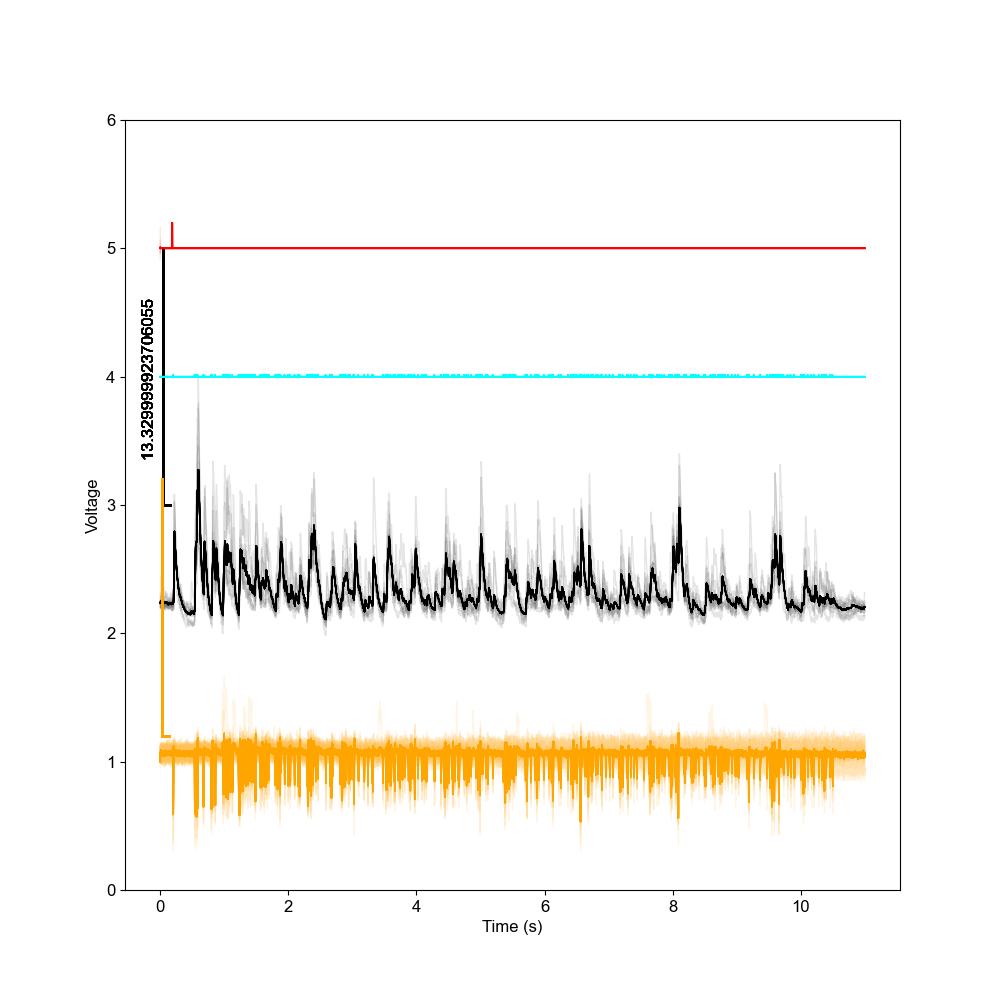

In [7]:
# plot
plot_tools.plot_data_from_df(df.iloc[-10:,:], data_start_column=49, combine=True)
# save fig
figure_name = 'Figure_poisson_spike_train_sample2.svg'
plt.savefig(paper_figure_export_location / (figure_name), dpi=300, bbox_inches='tight')

In [13]:
paper_figure_export_location

WindowsPath('paper_figures/Figure1v3_GRC')